# Global Path Variables

In [ ]:
base_path = "drive/MyDrive/Medical Data/"
EDA = "drive/MyDrive/Medical Data/EDA/"
pre_processing = "drive/MyDrive/Medical Data/PreProcessing/"
vit = "/content/drive/MyDrive/Medical Data/Vision_Transformer/"

# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import cv2
import gc

# Importing Deep learning Libraries
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import (InputLayer, BatchNormalization, Dropout, Flatten, multiply,
                                     Dense, Activation, MaxPool2D, GlobalAveragePooling2D,
                                     Conv2D, MaxPooling2D, SeparableConv2D, add, concatenate, DepthwiseConv2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, ReduceLROnPlateau
from keras import optimizers, Input
from keras.utils import plot_model
from keras.applications.imagenet_utils import decode_predictions
from keras.optimizers import Adam, RMSprop
from keras.metrics import Precision, Recall, AUC
from keras.backend import clear_session
# import tensorflow_addons as tfa


# Image read and show
import skimage.io
from skimage.io import imread, imshow

# Metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

2.12.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit memory growth for the GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the Dataset from h5 file..


In [ ]:
def load_hdf5_data(hdf5_path):
    f = h5py.File(hdf5_path, 'r')
    return f['image'], f['image_name'], f['image_label']

train_images, train_names, train_labels = load_hdf5_data(f'{base_path}Dataset5_raw_train.h5')
val_images, val_names, val_labels = load_hdf5_data(f'{base_path}Dataset5_raw_val.h5')
test_images, test_names, test_labels = load_hdf5_data(f'{base_path}Dataset5_raw_test.h5')

In [ ]:
def shuffle_data(images, names, labels):
    # Convert the HDF5 datasets to numpy arrays
    images = np.array(images)
    names = np.array(names)
    labels = np.array(labels)

    # Generate shuffled indices
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)

    # Use these indices to shuffle your data
    shuffled_images = images[indices]
    shuffled_names = names[indices]
    shuffled_labels = labels[indices]

    return shuffled_images, shuffled_names, shuffled_labels

# Shuffle the training data
train_images, train_names, train_labels = shuffle_data(train_images, train_names, train_labels)

# Shuffle the validation data
val_images, val_names, val_labels = shuffle_data(val_images, val_names, val_labels)

# Shuffle the test data
test_images, test_names, test_labels = shuffle_data(test_images, test_names, test_labels)


In [ ]:
def get_label_counts(labels):
    # Convert the HDF5 dataset to a numpy array first
    labels_np = np.array(labels)

    # Get the unique labels and their counts
    unique_labels, counts = np.unique(labels_np, return_counts=True)

    # Create a dictionary of label to count
    label_counts = dict(zip(unique_labels, counts))

    return label_counts

train_label_counts = get_label_counts(train_labels)
val_label_counts = get_label_counts(val_labels)
test_label_counts = get_label_counts(test_labels)

print("Training label counts:", train_label_counts)
print("Validation label counts:", val_label_counts)
print("Test label counts:", test_label_counts)

Training label counts: {0.0: 2512, 1.0: 3607, 2.0: 6115, 3.0: 4438, 4.0: 2938}
Validation label counts: {0.0: 836, 1.0: 1202, 2.0: 2038, 3.0: 1479, 4.0: 979}
Test label counts: {0.0: 838, 1.0: 1203, 2.0: 2039, 3.0: 1480, 4.0: 980}


# Class Label to Disease Name Mapping Dict

In [ ]:
"""
COVID-19 :  4,189 : 0
Lung-Opacity : 6,012 : 1
Normal : 10,192 : 2
Viral Pneumonia : 7,397 : 3
Tuberculosis : 4,897 : 4
"""

Label_ClassName_Dict = {
    0 : "COVID-19",
    1 : "Lung-Opacity",
    2 : "Normal",
    3 : "Viral Pneumonia",
    4 : "Tuberculosis",
}

ClassName_Dict_Label  = {v: k for k, v in Label_ClassName_Dict.items()}

float32 0.0 0.9370117 (224, 224, 3) 3
float32 0.0 0.8354492 (224, 224, 3) 3
float32 0.0 0.7998047 (224, 224, 3) 3
float32 0.0 0.98046875 (224, 224, 3) 3
float32 0.0 0.9609375 (224, 224, 3) 3


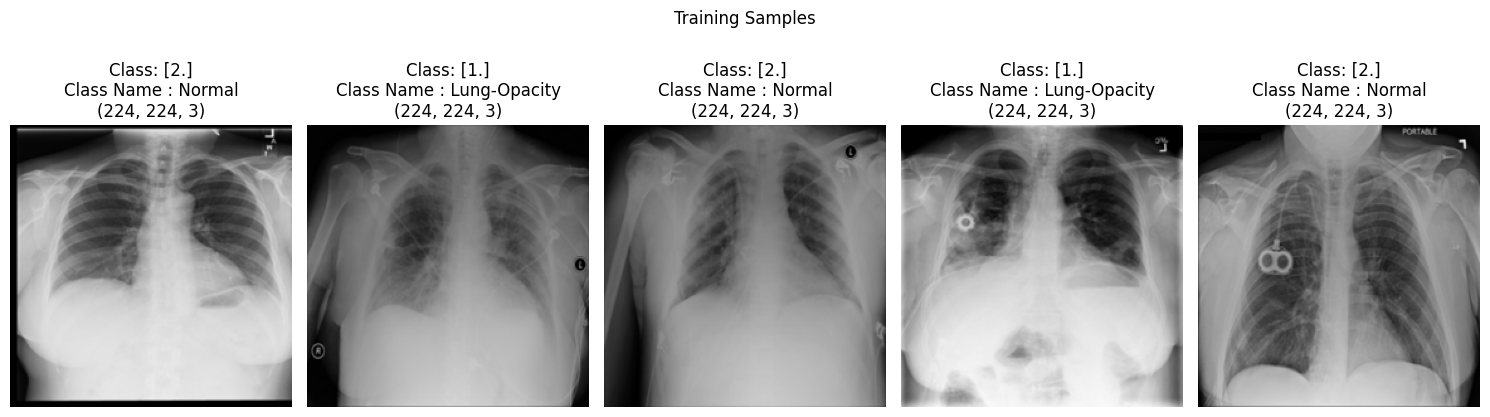

<Figure size 640x480 with 0 Axes>

In [ ]:
def display_samples(images, labels, path, num_samples=5, Type = "Training"):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        image = images[i]
        # Normalize the image if its values are not in the range [0, 1]
        # Convert the image to a suitable dtype
        if image.max() > 1:
            image = (image / 255.0).astype(np.float32)
        else:
            image = image.astype(np.float32)
        print(image.dtype, image.min(), image.max(), image.shape, len(image.shape))
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None) # Use gray colormap if the image is grayscale
        plt.title(f'Class: {labels[i]}\n' + f'Class Name : {Label_ClassName_Dict[int(labels[i].squeeze())]}\n' + f"{image.shape}")
        plt.axis('off')

    plt.suptitle(f"{Type} Samples")
    plt.tight_layout()
    plt.show()
    plt.savefig(path)

display_samples(train_images, train_labels, f"{pre_processing}Image_Samples.png")

# Image Pre-processing
1. CLAHE with grid size of 15 and clip size of 2.
2. Image Shapening with kernels.
3. Zoom for Handling Noise and Other Artifacts in the Dataset


*   Pre-Process : Hybrid CLAHE + Zoom + Image Sharpening




In [ ]:
"""
CLAHE
"""

# Function to apply CLAHE
def apply_clahe(img, grid_size=15, clip_limit=2.0):
    img = img.numpy()  # Convert tensor to numpy array
    img = img.astype(np.uint8)
    grid_size = int(grid_size)
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=(grid_size, grid_size))
    img_clahe = np.zeros_like(img)
    for channel in range(3):
        img_clahe[..., channel] = clahe.apply(img[..., channel])
    return img_clahe

"""
Image Shapening
"""

# kernels = [[[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]], # Basic Sharpening Kernel:
#            [[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]], # Laplacian Sharpening Kernel:
#            [[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]], # Diagonal Edge Sharpening:
#            [[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]], # Exaggerated Sharpening:
#            [[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]], # Another variant of Laplacian:
# ]

kernels = {
    "Basic Sharpening Kernel" : np.array([[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]]),
    "Laplacian Sharpening Kernel" : np.array([[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]]),
    "Diagonal Edge Sharpening" : np.array([[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]]) ,
    "Exaggerated Sharpening" : np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]]),
    "Another variant of Laplacian" : np.array([[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]],) ,
}

# Function to sharpen image
def sharpen_image(img, kernel= kernels["Basic Sharpening Kernel"]):
    img = img.numpy()
    img = img.astype(np.uint8)
    kernel = np.array(kernel)
    return cv2.filter2D(img, -1, kernel)


"""
Zoom Function - Handling Noise and Other Artifacts in the Dataset

1. Cropping / Zoom
2. Data Augmentation
3. Add Noise to the Images
"""

def zoom_into_chest_area(img, zoom_factor=0.83):
    """
    Zooms into the central region of a given X-ray image (assuming the chest area is centrally located).

    Args:
    - img_np: A numpy ndarray representing the X-ray image.
    - zoom_factor: Factor by which to zoom into the image. Values less than 1 zoom in.

    Returns:
    - A numpy ndarray representing the zoomed image.
    """
    img_np = img.numpy().copy().astype("uint8")
    if not isinstance(img_np, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    # Calculate the dimensions of the portion to zoom into
    center_x, center_y = img_np.shape[1] // 2, img_np.shape[0] // 2
    width_zoomed = img_np.shape[1] * zoom_factor
    height_zoomed = img_np.shape[0] * zoom_factor

    # Define ROI boundaries
    x1 = int(center_x - width_zoomed // 2)
    x2 = int(center_x + width_zoomed // 2)
    y1 = int(center_y - height_zoomed // 2)
    y2 = int(center_y + height_zoomed // 2)

    # Extract the region of interest from the image
    zoomed_roi = img_np[y1:y2, x1:x2]

    # Resize the ROI to the original image dimensions
    zoomed_img = cv2.resize(zoomed_roi, (img_np.shape[1], img_np.shape[0]))

    return zoomed_img

def crop_and_resize_image_np(img, crop_percentage=0.1):
    """
    Crops and then resizes a given image using numpy and OpenCV.

    Args:
    - img_np: A numpy ndarray representing the image.
    - crop_percentage: Percentage of the image's height to crop from each side.

    Returns:
    - A numpy ndarray representing the cropped and resized image.
    """

    img_np = img.numpy().copy().astype("uint8")
    if not isinstance(img_np, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    # Calculate the dimensions of the portion to crop
    height, width = img_np.shape[0], img_np.shape[1]

    # Calculate crop size
    crop_size = int(height * crop_percentage)

    # Get the coordinates to crop the image
    x1, x2 = crop_size, width - crop_size
    y1, y2 = crop_size, height - crop_size

    # Crop the image
    cropped_img = img_np[y1:y2, x1:x2]

    # Resize the cropped image to the original dimensions
    resized_img = cv2.resize(cropped_img, (width, height))

    return resized_img

def add_noise_np(img, stddev=0.1):
    """
    Adds Gaussian noise to a given numpy image.

    Args:
    - img_np: A numpy ndarray representing the image.
    - stddev: Standard deviation of the Gaussian noise.

    Returns:
    - A numpy ndarray representing the image with added noise.
    """
    img_np = img.numpy().copy().astype(np.uint8)
    if not isinstance(img_np, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    # Ensure the image is in float32 for the noise addition
    img_float = img_np.astype(np.float32)

    # Create noise and add to the image
    noise = np.random.normal(loc=0, scale=stddev, size=img_np.shape)
    noisy_img = img_float + noise

    # Clip values to [0, 255] if your image has pixel values in that range
    noisy_img_clipped = np.clip(noisy_img, 0, 255)

    # Convert back to uint8
    noisy_img_uint8 = noisy_img_clipped.astype(np.uint8)

    return noisy_img_uint8

"""
Pre-Process and Visualisation Functions
"""

# Apply CLAHE, zoom, and then sharpening transformations to images
def preprocess_images(image, label):
    image = tf.py_function(zoom_into_chest_area, [image], tf.uint8)
    image = tf.py_function(apply_clahe, [image], tf.uint8)
    image = tf.py_function(sharpen_image, [image], tf.uint8)
    return image, label


def rescale_image(img):
    return (img - img.min()) / (img.max() - img.min())

## Create Tensorflow Datasets from HDF5 files.


In [ ]:
# Create a TF Dataset
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

## Apply Pre-Processing

In [ ]:
with tf.device('/cpu:0'):
    # Training set Pre-Processing
    train_dataset_preprocessed = train_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Validation set Pre-Processing
    val_dataset_preprocessed = val_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Testing set Pre-Processing
    test_dataset_preprocessed = test_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Set Seed and Other Parameters

In [ ]:
Seed = 123
Batch_Size = 128
Image_Size = 224
num_classes = 5
BUFFER_SIZE = 19610
np.random.seed(Seed)
tf.random.set_seed(Seed)

# Vision Transformer

1. Image preprocess

*   scaling + 0 centering
*   Shuffling, Batching and One Hot Encoding

2. Training from Scratch.



## Scaling and 0 centering

In [ ]:
"""
1. ResNet50 Pre Process
"""
# Scaling
def scaling(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
with tf.device('/cpu:0'):
    train_dataset_scaled = train_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset_scaled = val_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset_scaled = test_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Zero Centering
with tf.device('/cpu:0'):

    def accumulate_images(img, label):
        return tf.reduce_sum(img, axis=0), tf.shape(img)[0]

    # Map the accumulate function onto the dataset and reduce to get global sum and count
    accumulated_data = train_dataset_scaled.map(accumulate_images).reduce(
        (tf.zeros([224, 224, 3]), 0),
        lambda x, y: (x[0] + y[0], x[1] + y[1])
    )

    # Compute the mean
    mean_image = accumulated_data[0] / tf.cast(accumulated_data[1], tf.float32)


In [ ]:
# Zero-centering
def zero_center(image, label):
    return image - mean_image, label

with tf.device('/cpu:0'):
      # Apply zero-centering to the datasets
      train_dataset_scaled_centered = train_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      val_dataset_scaled_centered = val_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      test_dataset_scaled_centered = test_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)


## Shuffling the images

In [ ]:
print(f"Buffer Size : {BUFFER_SIZE}")

# train_dataset_normalized = train_dataset_normalized.shuffle(BUFFER_SIZE)
train_dataset_scaled_centered = train_dataset_scaled_centered.shuffle(4096)
# test_dataset_scaled_centered = test_dataset_scaled_centered.shuffle(2048)
val_dataset_scaled_centered = val_dataset_scaled_centered.shuffle(4096)

Buffer Size : 19610


## Scaling , Batching and One Hot Encoding

In [ ]:
num_classes = 5

def one_hot_encode_batched(images, labels):
    labels = tf.cast(labels, tf.int32)
    labels = tf.one_hot(labels, depth=num_classes)
    labels = tf.squeeze(labels, axis = 1)  # Remove unnecessary dimensions
    return images, labels

In [ ]:
# Scaled , 0 centered dataset Batch and Prefetch
train_dataset_scaled_centered_batched_onehot = (train_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset_scaled_centered_batched_onehot = (val_dataset_scaled_centered
                                              # .shuffle(BUFFER_SIZE)
                                              .batch(Batch_Size)
                                              .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                              # .shuffle(BUFFER_SIZE//Batch_Size)
                                              .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset_scaled_centered_batched_onehot = (test_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

## Fine Tuning train_dataset_scaled_centered_batched_onehot Dataset.


In [ ]:
# GCW : Global Class Based Weighting
total_samples = 2512 + 3607 + 6115 + 4438 + 2938

# Calculate the global class-based weights
weights = {
    'COVID-19':  total_samples / (num_classes * 2512),
    'Lung-Opacity':  total_samples / (num_classes * 3607),
    'Normal':  total_samples / (num_classes * 6115),
    'Viral Pneumonia':  total_samples / (num_classes * 4438),
    'Tuberculosis':  total_samples / (num_classes * 2938)
}

int_weights = {ClassName_Dict_Label[key]: value for key, value in weights.items()}
print(int_weights)

{0: 1.5613057324840764, 1: 1.0873301912947047, 2: 0.6413736713000817, 3: 0.8837314105452907, 4: 1.334921715452689}


In [ ]:
steps_per_epoch = total_samples // Batch_Size
print('steps per epoch: ',steps_per_epoch + 1)

steps per epoch:  154


## Delete un-necessary Files to free up System Ram.

In [ ]:
del mean_image
del test_images, test_dataset, test_dataset_preprocessed, test_dataset_scaled, test_dataset_scaled_centered
del train_images, train_dataset, train_dataset_preprocessed, train_dataset_scaled, train_dataset_scaled_centered
del val_images, val_dataset, val_dataset_preprocessed, val_dataset_scaled, val_dataset_scaled_centered
del test_labels, train_labels, val_labels

In [ ]:
del train_names, val_names, test_names
gc.collect()

294

In [ ]:
# Count samples per class per batch for the first 20 batches
for i, (_, labels) in enumerate(train_dataset_scaled_centered_batched_onehot.take(20)):
    class_counts = tf.reduce_sum(labels, axis=0)
    print(f"Batch {i+1} class counts: {class_counts.numpy()}")

Batch 1 class counts: [10. 21. 39. 37. 21.]
Batch 2 class counts: [15. 29. 44. 28. 12.]
Batch 3 class counts: [21. 15. 43. 37. 12.]
Batch 4 class counts: [19. 22. 35. 34. 18.]
Batch 5 class counts: [12. 20. 39. 37. 20.]
Batch 6 class counts: [19. 23. 36. 36. 14.]
Batch 7 class counts: [17. 29. 43. 18. 21.]
Batch 8 class counts: [18. 30. 37. 24. 19.]
Batch 9 class counts: [24. 25. 27. 30. 22.]
Batch 10 class counts: [25. 24. 34. 29. 16.]
Batch 11 class counts: [13. 27. 32. 34. 22.]
Batch 12 class counts: [24. 28. 27. 31. 18.]
Batch 13 class counts: [16. 23. 47. 29. 13.]
Batch 14 class counts: [19. 22. 41. 26. 20.]
Batch 15 class counts: [19. 22. 42. 27. 18.]
Batch 16 class counts: [15. 28. 39. 26. 20.]
Batch 17 class counts: [15. 22. 49. 25. 17.]
Batch 18 class counts: [21. 25. 39. 28. 15.]
Batch 19 class counts: [15. 23. 44. 24. 22.]
Batch 20 class counts: [16. 24. 41. 27. 20.]


In [ ]:
# Count samples per class per batch for the first 20 batches
for i, (_, labels) in enumerate(val_dataset_scaled_centered_batched_onehot.take(20)):
    class_counts = tf.reduce_sum(labels, axis=0)
    print(f"Batch {i+1} class counts: {class_counts.numpy()}")

Batch 1 class counts: [16. 22. 40. 31. 19.]
Batch 2 class counts: [15. 19. 44. 30. 20.]
Batch 3 class counts: [18. 26. 43. 25. 16.]
Batch 4 class counts: [15. 24. 38. 27. 24.]
Batch 5 class counts: [17. 27. 45. 25. 14.]
Batch 6 class counts: [18. 26. 37. 26. 21.]
Batch 7 class counts: [22. 26. 37. 20. 23.]
Batch 8 class counts: [17. 18. 38. 34. 21.]
Batch 9 class counts: [17. 27. 35. 30. 19.]
Batch 10 class counts: [17. 24. 39. 30. 18.]
Batch 11 class counts: [16. 16. 43. 35. 18.]
Batch 12 class counts: [16. 15. 44. 35. 18.]
Batch 13 class counts: [15. 22. 43. 29. 19.]
Batch 14 class counts: [18. 22. 41. 29. 18.]
Batch 15 class counts: [15. 26. 46. 26. 15.]
Batch 16 class counts: [14. 27. 48. 32.  7.]
Batch 17 class counts: [26. 24. 38. 22. 18.]
Batch 18 class counts: [18. 21. 44. 27. 18.]
Batch 19 class counts: [20. 23. 41. 26. 18.]
Batch 20 class counts: [18. 18. 34. 29. 29.]


## Vision Transformer - From Scratch

In [ ]:
def Confusion_Matrix_Heatmap(y_test,y_pred,class_Names, fName, ModelName):
    #Plot the confusion matrix to understand the classification in detail
    CM = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.heatmap(CM, cmap='Greens', annot=True, fmt='d', xticklabels=class_Names, yticklabels=class_Names)
    plt.title(f'Disease Diagnosis from CXR images - {ModelName}')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.savefig(f"{vit}{fName}")
    #plt.show(ax)

# Plot Evaluation Metrics
# sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')
def Eval_Plot(acc,val_acc, loss,val_loss, auc, val_auc, precision, val_precision, path, title):

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(f"{title}\n", fontsize = 15)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize = 15)
    ax1.set_xlabel('Epochs', fontsize = 15)
    ax1.set_ylabel('Accuracy', fontsize = 15)
    ax1.legend(['Training', 'Validation'], fontsize = 15)


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize = 15)
    ax2.set_xlabel('Epochs', fontsize = 15)
    ax2.set_ylabel('Loss', fontsize = 15)
    ax2.legend(['Training', 'Validation'], fontsize = 15)

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC', fontsize = 15)
    ax3.set_xlabel('Epochs', fontsize = 15)
    ax3.set_ylabel('AUC', fontsize = 15)
    ax3.legend(['Training', 'Validation'], fontsize = 15)

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision', fontsize = 15)
    ax4.set_xlabel('Epochs', fontsize = 15)
    ax4.set_ylabel('Precision', fontsize = 15)
    ax4.legend(['Training', 'Validation'], fontsize = 15)

    plt.savefig(f"{vit}{path}")
    #plt.show()

In [ ]:
tf.keras.backend.clear_session()

### Configure the hyperparameters

In [ ]:
num_classes =5

learning_rate = 0.00001
# weight_decay = 0.0001

batch_size = 128
num_epochs = 100

image_size = 224  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 768

num_heads = 4

lr_reduction_factor = 0.3
lr_patience = 5
min_lr = 0.000000001
early_stopping_patience = 15

transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers

transformer_layers = 5

mlp_head_units = [1024, 1024]  # Size of the dense layers of the final classifier


### Modularized Vision Transformer:

1. Patches Extraction Module
2. Embedding Module (Class Token + Positional Embedding)
3. Transformer Block
4. Classification Head

In [ ]:
def get_positional_embedding(seq_len, d_model):
    """
    Returns positional embeddings of given shape
    """
    positions = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_emb = np.zeros((seq_len, d_model))
    pos_emb[:, 0::2] = np.sin(positions * div_term)
    pos_emb[:, 1::2] = np.cos(positions * div_term)
    return tf.convert_to_tensor(pos_emb[np.newaxis, ...], dtype=tf.float32)


# 1. Patches Extraction Module
class Patches(tf.keras.layers.Layer):
    def __init__(self):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        # Assuming images have 3 channels. Change if not the case.
        self.num_channels = 3

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = self.patch_size * self.patch_size * self.num_channels

        return tf.reshape(patches, [batch_size, -1, patch_dims])

# 2. Embedding Module
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.proj = Dense(projection_dim)
        seq_len = self.num_patches + 1  # +1 for the class token
        pos_emb = get_positional_embedding(seq_len, projection_dim)
        self.pos_emb = self.add_weight(
            "pos_emb",
            shape=(1, seq_len, projection_dim),
            initializer=keras.initializers.Zeros(),
            trainable=True
        )
        self.pos_emb.assign(pos_emb)  # Assign the initialized value to pos_emb

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        x = self.proj(patches)
        class_tokens = tf.zeros(shape=(batch_size, 1, self.proj.units))
        x = tf.concat([class_tokens, x], axis=1)
        return x + self.pos_emb


# 3. Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, mlp_units):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)
        # self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.mlp = Sequential(
            [
                Dense(mlp_units, activation=tf.keras.activations.gelu),
                tf.keras.layers.Dropout(0.5),
                Dense(projection_dim),
            ]
        )
        # self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.add = tf.keras.layers.Add()
        self.ln1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        x = self.ln1(inputs)
        x1 = self.att(x, x)
        # x1 = self.dropout1(x1, training=training)
        x = self.add([x, x1])
        x2 = self.ln2(x)
        x2_mlp = self.mlp(x2, training=training)
        # x2_mlp = self.dropout2(x2_mlp, training=training)
        return self.add([x, x2_mlp])

# 4. Classification Head
class ClassificationHead(tf.keras.layers.Layer):
    def __init__(self):
        super(ClassificationHead, self).__init__()

        # Initializer for the Dense layers
        self.mlp_layers = []
        i = 0
        for units in mlp_head_units:
            self.mlp_layers.append(Dense(units, activation=tf.keras.activations.gelu))
            i += 1
            if i != len(mlp_head_units):
              self.mlp_layers.append(tf.keras.layers.Dropout(0.5))

        self.final_dense = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = inputs[:, 0]  # Consider the class token

        # Pass through MLP layers
        for layer in self.mlp_layers:
            x = layer(x)

        return self.final_dense(x)

def vision_transformer():
    inputs = Input(shape=(image_size, image_size, 3))

    patches_layer = Patches()
    patches = patches_layer(inputs)

    # Embed patches
    embed_layer = PatchEmbedding()
    x = embed_layer(patches)

    # Transformer layers
    units = [512,512,512,512,512]
    for _ , unit in zip(range(transformer_layers), units):
        transformer_block = TransformerBlock(mlp_units=unit)
        x = transformer_block(x)

    # Classification head
    classification_head = ClassificationHead()
    outputs = classification_head(x)

    return Model(inputs=inputs, outputs=outputs)


Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


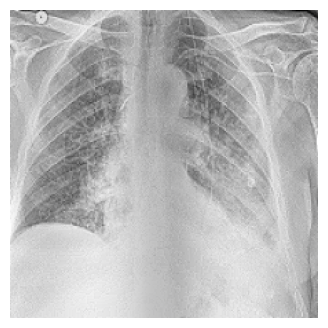

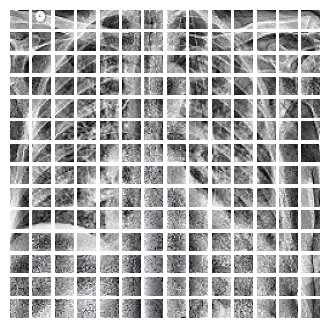

In [ ]:
for image, label in train_dataset_scaled_centered_batched_onehot.take(1):
  # Extract the patches
  # image = image.numpy()
  plt.figure(figsize=(4, 4))
  image_plot = rescale_image(image[0].numpy())
  image = np.expand_dims(image_plot, axis=0)
  plt.imshow(image_plot)
  plt.axis("off")

  patches = Patches()(image)
  print(f"Image size: {image_size} X {image_size}")
  print(f"Patch size: {patch_size} X {patch_size}")
  print(f"Patches per image: {patches.shape[1]}")
  print(f"Elements per patch: {patches.shape[-1]}")

  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(4, 4))
  for i, patch in enumerate(patches[0]):
      ax = plt.subplot(n, n, i + 1)
      patch_img = tf.reshape(patch, (patch_size, patch_size, 3))

      patch_img = rescale_image(patch_img.numpy())
      plt.imshow(patch_img)
      plt.axis("off")
  break

### Compile, train, and evaluate the mode

In [ ]:
def run_experiment(model, train_dataset, validation_dataset, test_dataset):
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )

    lr_reduce = ReduceLROnPlateau(monitor='val_auc',
                              factor=lr_reduction_factor,
                              patience=lr_patience,
                              verbose=1,
                              mode='max',
                              min_lr=min_lr)

    early_stopping_cb = EarlyStopping(monitor='val_auc',
                                      patience=early_stopping_patience,
                                      restore_best_weights=True,
                                      verbose=1,
                                      mode="max")

    checkpoint_filepath = "vit_checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    model.summary()
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=validation_dataset,
        verbose = 1,
        class_weight=int_weights,
        callbacks = [lr_reduce, early_stopping_cb],
    )

    # Uncomment the line below if you want to load the best weights saved during training.
    # model.load_weights(checkpoint_filepath)

    _, accuracy, precision, recall, auc, top_2_accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test precision: {round(precision * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test AUC: {auc}")
    print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")

    return history

# Now to use the function:
# Ensure your data variables are named appropriately: X_train, y_train, X_test, y_test
vit_classifier = vision_transformer()

history = run_experiment(vit_classifier, train_dataset_scaled_centered_batched_onehot, val_dataset_scaled_centered_batched_onehot, test_dataset_scaled_centered_batched_onehot)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 patches_1 (Patches)         (None, None, 768)         0         
                                                                 
 patch_embedding (PatchEmbed  (None, 197, 768)         741888    
 ding)                                                           
                                                                 
 transformer_block (Transfor  (None, 197, 768)         10237952  
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 197, 768)         10237952  
 ormerBlock)                                                     
                                                             

In [ ]:
from keras.saving.saving_api import load_weights
with tf.device('/gpu:0'):
    # best_model_path = f"{customCNN}customCNN_attention.h5"
    best_model_path = f"{vit}vit.h5"
    vit_classifier.save(best_model_path)
    vit_classifier.load_weights(filepath=f'{best_model_path}')

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
from keras.saving.saving_api import load_weights
with tf.device('/gpu:0'):
    vit_classifier = vision_transformer()
    # best_model_path = f"{customCNN}customCNN_attention.h5"
    best_model_path = f"{vit}vit.h5"
    vit_classifier.load_weights(filepath=f'{best_model_path}')

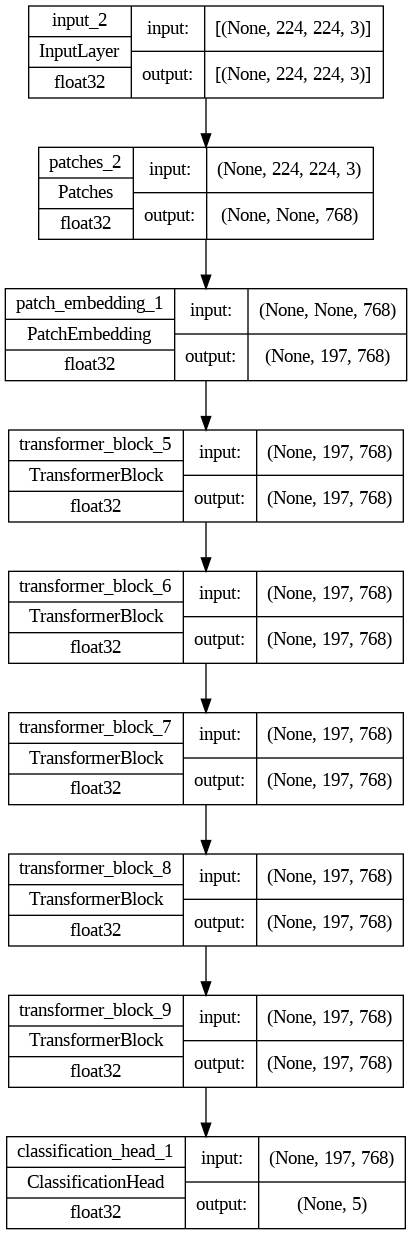

In [ ]:
plot_model(
    vit_classifier,
    to_file=f"{vit}Vit_Custom.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.projection_dim = projection_dim
        self.token_embed = tf.keras.layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)

    def build(self, input_shape):
        self.pos_embed = self.add_weight("pos_embed", shape=(1, input_shape[1] + 1, self.projection_dim), initializer='zeros', trainable=True)
        self.class_token = self.add_weight("class_token", shape=(1, 1, self.projection_dim), initializer='zeros', trainable=True)
        super(TokenAndPositionEmbedding, self).build(input_shape)

    def call(self, patches):
        # Here we are adding the class token
        class_tokens = tf.broadcast_to(self.class_token, [tf.shape(patches)[0], 1, self.projection_dim])
        x = tf.concat([class_tokens, patches], axis=1)
        return x + self.pos_embed

def VisionTransformer(
    image_size, patch_size, num_classes, num_transformer_blocks,
    projection_dim, num_heads, mlp_units, dropout_rate
):
    inputs = Input(shape=(image_size, image_size, 3))

    # Image Tokenization
    patches = tf.image.extract_patches(
        images=inputs,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    patches = tf.keras.layers.Reshape((patches.shape[1]*patches.shape[2], patch_size*patch_size*3))(patches)
    patch_embeddings = Dense(projection_dim)(patches)

    # position embedding and class token logic
    embed_layer = TokenAndPositionEmbedding(num_patches, projection_dim)
    tokens_with_class = embed_layer(patch_embeddings)

    # Transformer Encoder
    for _ in range(num_transformer_blocks):
        # Layer normalization
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(tokens_with_class)

        # Multi-Head Self Attention
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)(x, x)
        x = tf.keras.layers.Add()([attention_output, tokens_with_class])


        # MLP
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        mlp_output = Dense(mlp_units[0], activation='relu')(x)
        mlp_output = Dropout(dropout_rate)(mlp_output)
        mlp_output = Dense(mlp_units[1])(mlp_output)
        tokens_with_class = tf.keras.layers.Add()([mlp_output, x])

    # Attention-based Pooling
    # Use a dense layer to produce attention scores for each token
    attention_scores = Dense(1, activation='softmax')(tokens_with_class)
    pooled_representation = tf.reduce_sum(tokens_with_class * attention_scores, axis=1)

    # Increasing Model Complexity
    # Add Dense layers
    pooled_representation = Dense(2096, activation='relu')(pooled_representation)
    pooled_representation = Dropout(0.4)(pooled_representation)
    pooled_representation = Dense(2096, activation='relu')(pooled_representation)

    # Optional: Incorporating Global Average Pooling
    # First, you'll need to adjust the shape of tokens_with_class to match GAP's expected input.
    gap_representation = tf.keras.layers.GlobalAveragePooling1D()(tokens_with_class)
    # You can then concatenate the GAP output with the attention-based pooled representation
    pooled_representation = tf.keras.layers.Concatenate()([pooled_representation, gap_representation])

    logits = Dense(num_classes, activation='softmax')(pooled_representation)

    model = Model(inputs=inputs, outputs=logits)
    return model


learning_rate = 0.00001
weight_decay = 1e-3
image_size = 224
patch_size = 20
num_classes = 5  # or the number of classes in your dataset
num_transformer_blocks = 5
projection_dim = 768
num_heads = 5
mlp_units = [3072, 768]  # Note: the second value should match projection_dim
dropout_rate = 0.1

In [ ]:
# Linear Warm-up + Cosine Decay
class WarmUpAndCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super(WarmUpAndCosineDecay, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.cosine_decay = tf.keras.experimental.CosineDecay(
            initial_learning_rate=learning_rate_base, decay_steps=total_steps-warmup_steps
        )

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError('Total steps cannot be less than warmup steps.')

        learning_rate = (
            tf.where(
                tf.cast(step, tf.float32) < self.warmup_steps,
                self.warmup_learning_rate * (tf.cast(step, tf.float32) / self.warmup_steps),
                self.cosine_decay(tf.cast(step, tf.float32) - self.warmup_steps)
            )
        )
        return learning_rate

    # Add the following method:
    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'warmup_steps': self.warmup_steps,
        }


def run_experiment(model, train_dataset, validation_dataset, test_dataset):

    # Parameters
    train_steps_per_epoch = np.ceil(19610 / batch_size).astype(int)
    total_steps = train_steps_per_epoch * num_epochs

    warmup_learning_rate = 0.00001
    warmup_steps = int(train_steps_per_epoch * num_epochs * 0.1)  # warmup for 10% of training
    lr_schedule = WarmUpAndCosineDecay(learning_rate, total_steps, warmup_learning_rate, warmup_steps)

    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay= weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )

    lr_reduce = ReduceLROnPlateau(monitor='val_auc',
                              factor=lr_reduction_factor,
                              patience=lr_patience,
                              verbose=1,
                              mode='max',
                              min_lr=min_lr)


    early_stopping_cb = EarlyStopping(monitor='val_auc',
                                      patience=early_stopping_patience,
                                      restore_best_weights=True,
                                      verbose=1,
                                      mode="max")

    checkpoint_filepath = "vit_checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    model.summary()
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=validation_dataset,
        verbose = 1,
        class_weight=int_weights,
        callbacks = [early_stopping_cb],
    )

    # Uncomment the line below if you want to load the best weights saved during training.
    # model.load_weights(checkpoint_filepath)

    _, accuracy, precision, recall, auc, top_2_accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test precision: {round(precision * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test AUC: {auc}")
    print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")

    return history

# Now to use the function:
# Ensure your data variables are named appropriately: X_train, y_train, X_test, y_test
vit_model = VisionTransformer(
    image_size, patch_size, num_classes, num_transformer_blocks,
    projection_dim, num_heads, mlp_units, dropout_rate
)

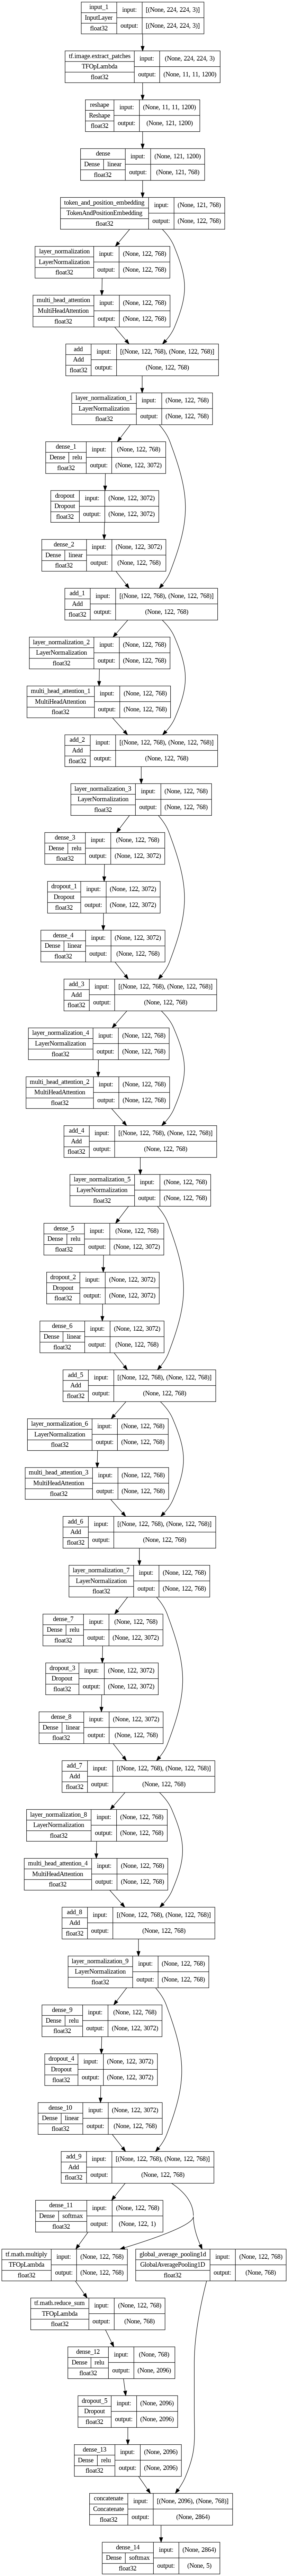

In [ ]:
plot_model(
    vit_model,
    to_file=f"{vit}Vit_B16_DownSized.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


In [ ]:
vit_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.extract_patches (TFOp  (None, 11, 11, 1200  0          ['input_1[0][0]']                
 Lambda)                        )                                                                 
                                                                                                  
 reshape (Reshape)              (None, 121, 1200)    0           ['tf.image.extract_patches[0][0]'
                                                                 ]                            

In [ ]:
history_secondModel = run_experiment(vit_model, train_dataset_scaled_centered_batched_onehot, val_dataset_scaled_centered_batched_onehot, test_dataset_scaled_centered_batched_onehot)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.extract_patches (TFOp  (None, 11, 11, 1200  0          ['input_1[0][0]']                
 Lambda)                        )                                                                 
                                                                                                  
 reshape (Reshape)              (None, 121, 1200)    0           ['tf.image.extract_patches[0][0]'
                                                                 ]                            

### Plot

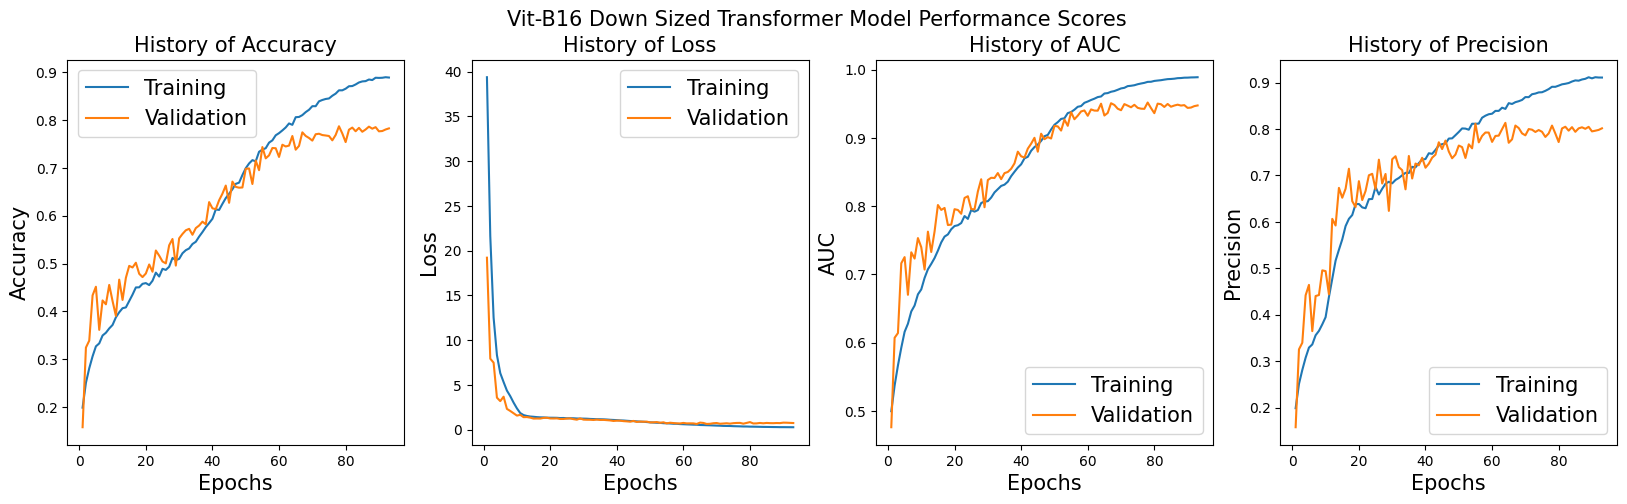

In [ ]:
path = "loss_acc.png"
title = "Vit-B16 Down Sized Transformer Model Performance Scores"
Eval_Plot(
    history_secondModel.history['accuracy'],history_secondModel.history['val_accuracy'],
    history_secondModel.history['loss'],history_secondModel.history['val_loss'],
    history_secondModel.history['auc'],history_secondModel.history['val_auc'],
    history_secondModel.history['precision'],history_secondModel.history['val_precision'],
    path, title
)

In [ ]:
# Linear Warm-up + Cosine Decay
class WarmUpAndCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super(WarmUpAndCosineDecay, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.cosine_decay = tf.keras.experimental.CosineDecay(
            initial_learning_rate=learning_rate_base, decay_steps=total_steps-warmup_steps
        )

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError('Total steps cannot be less than warmup steps.')

        learning_rate = (
            tf.where(
                tf.cast(step, tf.float32) < self.warmup_steps,
                self.warmup_learning_rate * (tf.cast(step, tf.float32) / self.warmup_steps),
                self.cosine_decay(tf.cast(step, tf.float32) - self.warmup_steps)
            )
        )
        return learning_rate

    # Add the following method:
    def get_config(self):
        return {
            'learning_rate_base': self.learning_rate_base,
            'total_steps': self.total_steps,
            'warmup_learning_rate': self.warmup_learning_rate,
            'warmup_steps': self.warmup_steps
        }

In [ ]:
# Parameters
with tf.device('/gpu:0'):
    train_steps_per_epoch = np.ceil(19610 / batch_size).astype(int)
    total_steps = train_steps_per_epoch * num_epochs

    warmup_learning_rate = 0.00001
    warmup_steps = int(train_steps_per_epoch * num_epochs * 0.1)  # warmup for 10% of training
    lr_schedule = WarmUpAndCosineDecay(learning_rate, total_steps, warmup_learning_rate, warmup_steps)

    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay= weight_decay)

    vit_model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )

In [ ]:
from keras.saving.saving_api import load_weights
with tf.device('/gpu:0'):
    best_model_path = f"{vit}VitB16_DownSized.h5"
    # vit_model.save(best_model_path)
    vit_model.load_weights(filepath=f'{best_model_path}')

In [ ]:
# Getting predictions
with tf.device('/gpu:0'):
    predictions = vit_model.predict(test_dataset_scaled_centered_batched_onehot)

y_pred = predictions.argmax(axis=-1)

# Retrieving labels from dataset
y_labels_list = []
for _, labels in test_dataset_scaled_centered_batched_onehot:
    # Here, we're assuming that the labels are one-hot encoded
    # So, we get the integer label for each sample in the batch
    y_labels_list.append(tf.argmax(labels, axis=-1))

# Stacking batches together
y_label = tf.concat(y_labels_list, axis=0).numpy()

# Retrieve class names from the ClassName_Dict_Label
class_Names = [class_name for class_name, _ in sorted(ClassName_Dict_Label.items(), key=lambda item: item[1])]

52/52 [==============================] - 852s 16s/step


In [ ]:
assert y_pred.shape == y_label.shape

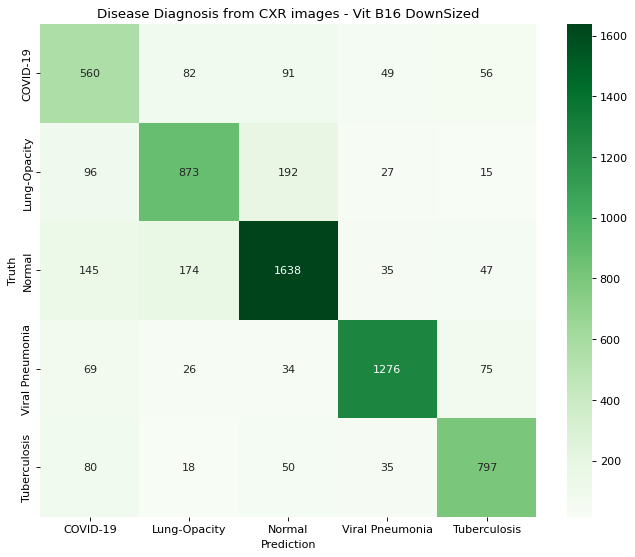

In [ ]:
Confusion_Matrix_Heatmap(y_label, y_pred, class_Names, f"HeatMap.jpeg", "Vit B16 DownSized")

In [ ]:
print(classification_report(y_label, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.67      0.63       838
           1       0.74      0.73      0.73      1203
           2       0.82      0.80      0.81      2039
           3       0.90      0.86      0.88      1480
           4       0.81      0.81      0.81       980

    accuracy                           0.79      6540
   macro avg       0.77      0.77      0.77      6540
weighted avg       0.79      0.79      0.79      6540



### Scores

In [ ]:
scores_Custom_vit = vit_model.evaluate(test_dataset_scaled_centered_batched_onehot)

52/52 [==============================] - 33s 616ms/step - loss: 0.6624 - accuracy: 0.7865 - precision: 0.8116 - recall: 0.7615 - auc: 0.9513 - top-2-accuracy: 0.9365


In [ ]:
print(f"Accuracy in test set  : {scores_Custom_vit[1]}")
print(f"Precision in test set : {scores_Custom_vit[2]}")
print(f"Recall in test set    : {scores_Custom_vit[3]}")
print(f"AUC in test set       : {scores_Custom_vit[4]}")

Accuracy in test set  : 0.7865443229675293
Precision in test set : 0.8116036653518677
Recall in test set    : 0.7614678740501404
AUC in test set       : 0.9513270258903503


In [ ]:
import pandas as pd
Scores = pd.DataFrame([scores_Custom_vit], columns = ["Loss", "Test Accuracy", "Precision", "Recall", "AUC", "Top-2-Accuracy"])
Scores

,Loss,Test Accuracy,Precision,Recall,AUC,Top-2-Accuracy
0,0.662379,0.786544,0.811604,0.761468,0.951327,0.936544


In [ ]:
Scores.to_csv(f"{vit}score.csv")

In [ ]:
vit_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.extract_patches (TFOp  (None, 11, 11, 1200  0          ['input_1[0][0]']                
 Lambda)                        )                                                                 
                                                                                                  
 reshape (Reshape)              (None, 121, 1200)    0           ['tf.image.extract_patches[0][0]'
                                                                 ]                            

## Attention Visualization

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def VisionTransformer_with_attention(
    image_size, patch_size, num_classes, num_transformer_blocks,
    projection_dim, num_heads, mlp_units, dropout_rate
):
    inputs = Input(shape=(image_size, image_size, 3))

    # Image Tokenization
    patches = tf.image.extract_patches(
        images=inputs,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    patches = tf.keras.layers.Reshape((patches.shape[1]*patches.shape[2], patch_size*patch_size*3))(patches)
    patch_embeddings = Dense(projection_dim)(patches)

    # position embedding and class token logic
    embed_layer = TokenAndPositionEmbedding(num_patches, projection_dim)
    tokens_with_class = embed_layer(patch_embeddings)

    # Transformer Encoder
    all_attention_scores = []

    for _ in range(num_transformer_blocks):
        # Layer normalization
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(tokens_with_class)

        # Multi-Head Self Attention with attention scores
        attention_output , attention_scores = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)(x, x, return_attention_scores=True)
        all_attention_scores.append(attention_scores)
        x = tf.keras.layers.Add()([attention_output, tokens_with_class])


        # MLP
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        mlp_output = Dense(mlp_units[0], activation='relu')(x)
        mlp_output = Dropout(dropout_rate)(mlp_output)
        mlp_output = Dense(mlp_units[1])(mlp_output)
        tokens_with_class = tf.keras.layers.Add()([mlp_output, x])

    # Attention-based Pooling
    # Use a dense layer to produce attention scores for each token
    attention_scores = Dense(1, activation='softmax')(tokens_with_class)
    pooled_representation = tf.reduce_sum(tokens_with_class * attention_scores, axis=1)

    # Increasing Model Complexity
    # Add Dense layers
    pooled_representation = Dense(2096, activation='relu')(pooled_representation)
    pooled_representation = Dropout(0.4)(pooled_representation)
    pooled_representation = Dense(2096, activation='relu')(pooled_representation)

    # Optional: Incorporating Global Average Pooling
    # First, you'll need to adjust the shape of tokens_with_class to match GAP's expected input.
    gap_representation = tf.keras.layers.GlobalAveragePooling1D()(tokens_with_class)
    # You can then concatenate the GAP output with the attention-based pooled representation
    pooled_representation = tf.keras.layers.Concatenate()([pooled_representation, gap_representation])

    prob = Dense(num_classes, activation='softmax')(pooled_representation)

    model = Model(inputs=inputs, outputs=[prob, all_attention_scores])
    return model

In [ ]:
# Create the model
model_with_attention = VisionTransformer_with_attention(
    image_size, patch_size, num_classes, num_transformer_blocks,
    projection_dim, num_heads, mlp_units, dropout_rate
)

# Load weights from your trained model
best_model_path = f"{vit}VitB16_DownSized.h5"
model_with_attention.load_weights(f"{best_model_path}", by_name=True)  # by_name ensures it only loads weights for layers with matching names.

In [ ]:
# Extracting the layer names
for layer in model_with_attention.layers:
    print('Layer name:', layer.name)

Layer name: input_1
Layer name: tf.image.extract_patches
Layer name: reshape
Layer name: dense
Layer name: token_and_position_embedding
Layer name: layer_normalization
Layer name: multi_head_attention
Layer name: add
Layer name: layer_normalization_1
Layer name: dense_1
Layer name: dropout
Layer name: dense_2
Layer name: add_1
Layer name: layer_normalization_2
Layer name: multi_head_attention_1
Layer name: add_2
Layer name: layer_normalization_3
Layer name: dense_3
Layer name: dropout_1
Layer name: dense_4
Layer name: add_3
Layer name: layer_normalization_4
Layer name: multi_head_attention_2
Layer name: add_4
Layer name: layer_normalization_5
Layer name: dense_5
Layer name: dropout_2
Layer name: dense_6
Layer name: add_5
Layer name: layer_normalization_6
Layer name: multi_head_attention_3
Layer name: add_6
Layer name: layer_normalization_7
Layer name: dense_7
Layer name: dropout_3
Layer name: dense_8
Layer name: add_7
Layer name: layer_normalization_8
Layer name: multi_head_attention_4

In [ ]:
# This function visualizes the attention map on the image
def visualize_attention(image, attention_weights, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.axis('off')

    # Resize attention weights to match image size
    attention_map = tf.image.resize(tf.expand_dims(attention_weights, -1), [image.shape[0], image.shape[1]])
    attention_map = rescale_image(tf.squeeze(attention_map, -1).numpy())

    # Superimpose the attention map on the image
    ax.imshow(image)
    # ax.imshow(attention_map, cmap='viridis', alpha=0.5)
    ax.imshow(attention_map, cmap='jet', alpha = 0.5)

def rescale_image(image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

# Define a helper function to plot images and attention
def plot_images_and_attention(images, attention_weights, ground_truth_labels, predicted_labels):
    num_images = len(images)

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))

    for i in range(num_images):
        # Original Image
        image = rescale_image(images[i].numpy())
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f'GT: {ground_truth_labels[i]}, Pred: {predicted_labels[i]}')
        axes[i, 0].axis('off')

        # Attention Map
        ax = axes[i, 1]
        # print(attention_weights.shape, [images[i].shape[0], images[i].shape[1]])
        attention_map = tf.image.resize(tf.expand_dims(attention_weights[i], -1),[images[i].shape[0], images[i].shape[1]])
        attention_map = rescale_image(tf.squeeze(attention_map, -1).numpy())
        ax.imshow(attention_map, cmap='jet')
        ax.set_title('Attention Map')
        ax.axis('off')

        # Superimposed Attention
        image = rescale_image(images[i].numpy())
        visualize_attention(image, attention_weights[i], ax=axes[i, 2])

    plt.tight_layout()
    plt.show()

# The upscale function to match attention weights to image size
def upscale_attention_to_image_size(attention_map, image_size, patch_size):
    num_patches_side = image_size // patch_size
    upscale_factor = image_size // num_patches_side

    upscaled_attention = tf.repeat(attention_map, upscale_factor, axis=0)
    upscaled_attention = tf.repeat(upscaled_attention, upscale_factor, axis=1)

    return upscaled_attention

# Extract 10 images, their attention maps, and labels
for batch_images, batch_labels in test_dataset_scaled_centered_batched_onehot.take(1):
    images_to_plot = batch_images[:10]
    y_pred, all_block_attention_weights = model_with_attention(images_to_plot)

    # Assuming you have a list of label names called `label_names` mapping indices to their string names
    ground_truth_labels = [Label_ClassName_Dict[i] for i in tf.argmax(batch_labels[:10], axis=-1).numpy()]
    predicted_label_names = [Label_ClassName_Dict[i] for i in tf.argmax(y_pred[:10], axis=-1).numpy()]

    for block_idx, attention_weights_block in enumerate(all_block_attention_weights):
        # Exclude class token and average over heads
        attention_weights = attention_weights_block[:, 1:, :]
        attention_weights = tf.reduce_mean(attention_weights, axis=-1)

        # Upscale the attention weights
        upscaled_attention_weights = []
        for i in range(attention_weights.shape[0]):
            upscaled_attention = upscale_attention_to_image_size(attention_weights[i], image_size, patch_size)
            upscaled_attention_weights.append(upscaled_attention)
        upscaled_attention_weights = tf.stack(upscaled_attention_weights)

        # Visualization
        print(f"Visualizing attention from block {block_idx + 1}")
        plot_images_and_attention(images_to_plot, upscaled_attention_weights, ground_truth_labels, predicted_label_names)
    break

Output hidden; open in https://colab.research.google.com to view.